In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.regularizers import l1, l2, l1_l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import os
import pandas as pd
import shutil

%matplotlib inline

In [2]:
# Data initialization
train_path = 'Training_Set'
test_path = 'Test_Set'
evalution_path='Evaluation_Set'

In [3]:
# Data generator configuration to transform the images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [4]:
# Scaling image pixel values
valid_datagen = ImageDataGenerator(rescale=1./255)# Generator configuration for validation

test_datagen = ImageDataGenerator(rescale=1./255)# Generator configuration for test

In [ ]:
csv_file = 'Training_Set/Training_Set/RFMiD_Training_Labels.csv'
images_folder = 'Training_Set/Training_Set/Training/'

# We need to create 2 new folders "Normal" and "Ill" for our training set
# Images will be sorted based on their health status
normal_folder = 'Normal/'
ill_folder = 'Ill/'
os.makedirs(normal_folder, exist_ok=True)
os.makedirs(ill_folder, exist_ok=True)


df = pd.read_csv(csv_file)

# Extraction of the image ID and the value of the “Disease_Risk” : 
# If the image is associated with a disease: 1 or not: 0
for index, row in df.iterrows():
    image_id = row['ID']
    disease_risk = row['Disease_Risk']
    image_filename = f'{image_id}.png'

    if disease_risk == 1:

        src_path = os.path.join(images_folder, image_filename)
        dest_path = os.path.join(ill_folder, image_filename)
        shutil.move(src_path, dest_path)
    elif disease_risk == 0:

        src_path = os.path.join(images_folder, image_filename)
        dest_path = os.path.join(normal_folder, image_filename)
        shutil.move(src_path, dest_path)

print("Images have been sorted into 'Normal' and 'Ill' folders.")

In [5]:
# Image processing to increase the efficiency of the model
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),# Resized image
        batch_size=10, # Images loaded in batches of 10 at a time
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1920 images belonging to 2 classes.
Found 640 images belonging to 1 classes.


In [6]:
# Display of a dictionary with the two cases: ill and normal and their Index 
train_generator.class_indices

{'Ill': 0, 'Normal': 1}

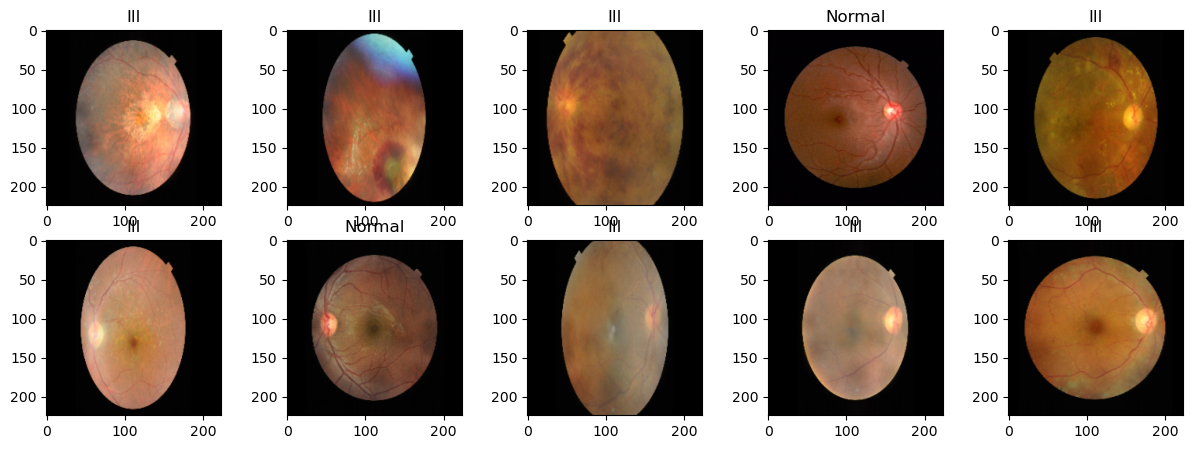

In [7]:
# Print 10 images from the train_generator with labels 'Ill' or 'Normal'
photos, labels = next(iter(train_generator))

plt.figure(figsize=(15, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(photos[i])
  if labels[i][0] == 1:
    plt.title('Ill')
  else:
    plt.title('Normal')

plt.show()

In [8]:
# To make predictions compare these predictions with the model labels
test_images, test_labels = next(iter(test_generator))

In [9]:
# Extracts first column of labels
bin_test_labels = test_labels[:, 0]

In [10]:
bin_test_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [11]:
# To create a model pre-trained
vgg19_model = VGG19(include_top=False, input_shape=(224, 224, 3))

In [12]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Only the final 6 layers of the VGG19 model will be trained
for layer in vgg19_model.layers[:-6]:
  layer.trainable = False

In [14]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Displays each layer
for layer in vgg19_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001B7F5D27DC0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F7BC8DF0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F7BC9540> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B7F7BCA680> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F7BCAE60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F7BCA950> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B7F78C49D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F7BCBC10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F78C5F30> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F78C63B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B7F78C73D0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B7F78C56F0> False
<keras.layers.convolutional.conv2d.Conv2D object

In [16]:
# Create a neural network model : sequential type
model = Sequential()

In [17]:
# Embed pre-trained VGG19 model inside sequential model 
model.add(vgg19_model)

In [18]:
model.add(Flatten())# transforms features into a 1D vector
model.add(Dense(1024, activation='relu')) # adds a fully connected layer with 1024 units
model.add(keras.layers.Dropout(0.30)) # randomly deactivates 30% of neurons
model.add(Dense(2, activation='softmax')) # two output classes

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 45,717,570
Trainable params: 35,132,418
Non-trainable params: 10,585,152
_________________________________________________________________


In [20]:
# Sets the learning rate to 0.00001
learning_rate = 0.00001

optimizer = Adam(lr=learning_rate)

C:\Users\carla\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
# Model compilation
model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

In [22]:
# Training the model using a data generator
history = model.fit(train_generator, 
                    steps_per_epoch=10, 
                    validation_steps=10,
                    verbose=2,
                    epochs=10)

Epoch 1/10
10/10 - 25s - loss: 0.5789 - accuracy: 0.7200 - 25s/epoch - 2s/step
Epoch 2/10
10/10 - 19s - loss: 0.5128 - accuracy: 0.8200 - 19s/epoch - 2s/step
Epoch 3/10
10/10 - 21s - loss: 0.4203 - accuracy: 0.8500 - 21s/epoch - 2s/step
Epoch 4/10
10/10 - 18s - loss: 0.4530 - accuracy: 0.8100 - 18s/epoch - 2s/step
Epoch 5/10
10/10 - 23s - loss: 0.5020 - accuracy: 0.8200 - 23s/epoch - 2s/step
Epoch 6/10
10/10 - 24s - loss: 0.4996 - accuracy: 0.7700 - 24s/epoch - 2s/step
Epoch 7/10
10/10 - 24s - loss: 0.5319 - accuracy: 0.7400 - 24s/epoch - 2s/step
Epoch 8/10
10/10 - 23s - loss: 0.4173 - accuracy: 0.8500 - 23s/epoch - 2s/step
Epoch 9/10
10/10 - 21s - loss: 0.5104 - accuracy: 0.7200 - 21s/epoch - 2s/step
Epoch 10/10
10/10 - 26s - loss: 0.4600 - accuracy: 0.8000 - 26s/epoch - 3s/step


In [23]:
# Make predictions using the model
predictions = model.predict(test_generator,
                            steps=len(test_generator),
                            verbose=1)

64/64 [==============================] - 115s 2s/step


In [24]:
# Evaluate the model
model.evaluate(test_generator)

64/64 [==============================] - 120s 2s/step - loss: 2.4532 - accuracy: 0.9281


[2.4532251358032227, 0.9281250238418579]

In [25]:
model.save('model_ML_data_camp_eyes.h5')